- Github: Bus/Network/Handle_Bus_Network.ipynb

**Object:**

- Convert raw data to shapefile and graph format

In [23]:
! pip install geopandas

In [24]:
import os
import sys

import numpy as np
import pandas as pd
import geopandas as gpd

import networkx as nx

from shapely.geometry import LineString, Point

In [25]:
# convert CRS
import pyproj

CRS_SVY21 = 'PROJCS["SVY21",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",28001.642],PARAMETER["False_Northing",38744.572],PARAMETER["Central_Meridian",103.833333333333],PARAMETER["Scale_Factor",1.0],PARAMETER["Latitude_Of_Origin",1.36666666666667],UNIT["Meter",1.0]]'
CRS_SVY21 = pyproj.CRS.from_string(CRS_SVY21)

# 0 Read Data

- Read Data

    - `bus_routes_*.csv`

    - `bus_stops_*.csv`

    - `BusStopLocation.zip`: Extract CRS

In [26]:
def read_route_and_stop(route_df_path, stop_df_path):
    '''
    route_df_path (str) : 
        route_df file: request from Datamall API 2_3_BUS_ROUTES
    
    stop_df_path (str) : 
        route_df file: request from Datamall API 2_4_BUS_STOPS
    '''
    route_df = pd.read_csv(route_df_path, header=0, index_col=None,
                           dtype = {'ServiceNo'    : str,
                                    'Operator'     : str,
                                    'StopSequence' : np.int16,
                                    'Direction'    : np.int8,
                                    'BusStopCode'  : str })
    
    stop_df = pd.read_csv(stop_df_path,
                          dtype = {'BusStopCode' : str})
    
    return route_df, stop_df
# =============================================================

In [27]:
# CRS
path = "zip://BusStopLocation.zip!BusStopLocation_Jun2022/BusStop.shp"
CRS = gpd.read_file(path).crs

route_df_path = 'bus_routes_2022-06-19.csv'
stop_df_path = 'bus_stops_2022-06-19.csv'
route_df, stop_df = read_route_and_stop(route_df_path, stop_df_path)

In [28]:
route_df = route_df.merge(right=stop_df, how = 'left',
                          on = 'BusStopCode')

# check if there exists some stops without location information 
stop_nan = route_df[route_df['Latitude'].isna()]['BusStopCode']
print(stop_nan)

Series([], Name: BusStopCode, dtype: object)


# 1 Creat Shapefile

## 1.1 Read data

## 1.2 Create Line Segment Shapefile

In [8]:
line_seg_gpd = pd.DataFrame(columns = ['start_stop', 'end_stop', 
                                       'service_no', 'operator', 'direction',
                                       'distance', 'geometry'])

for name, group in route_df.groupby(by = ['Operator', 'ServiceNo', 'Direction']):
    operator, service_no, direction = name
    
    # some stop may be repeated
    group.drop_duplicates(inplace=True)
    group.sort_values(by='StopSequence', ignore_index=True, inplace=True)
    
    for ix in range(group.shape[0] - 1):
        
        start_stop     = group.loc[ix, 'BusStopCode']
        start_stop_lat = group.loc[ix, 'Latitude']
        start_stop_lng = group.loc[ix, 'Longitude']
        start_stop_geo = Point(start_stop_lng, start_stop_lat)
        
        end_stop     = group.loc[ix+1, 'BusStopCode']
        end_stop_lat = group.loc[ix+1, 'Latitude']
        end_stop_lng = group.loc[ix+1, 'Longitude']
        end_stop_geo = Point(end_stop_lng, end_stop_lat)
        
        line_geo = LineString([start_stop_geo, end_stop_geo])
        line_dist = group.loc[ix+1, 'Distance'] - group.loc[ix, 'Distance']
        
        try:
            assert line_dist > 0.
        except:
            print(name, line_dist)
            # sys.exit(0)
            
        one_row = pd.Series({'start_stop' : start_stop,
                             'end_stop'   : end_stop, 
                             'service_no' : service_no, 
                             'operator'   : operator, 
                             'direction'  : direction, 
                             'distance'   : line_dist,        
                             'geometry'   : line_geo.wkt})
        one_row = one_row.to_frame().transpose()
        
        line_seg_gpd = pd.concat([line_seg_gpd, one_row], axis=0, ignore_index=True)

line_seg_gpd = gpd.GeoDataFrame(line_seg_gpd, 
                                geometry = gpd.GeoSeries.from_wkt(line_seg_gpd['geometry']),
                                crs = 'EPSG:4326')     

# modify the data type of 'direction' column
line_seg_gpd = line_seg_gpd.astype({'direction': np.int8})

line_seg_gpd

('GAS', '68', 1) 0.0
('SBST', '160', 1) 0.0
('SBST', '160', 1) 0.0
('SBST', '160', 1) 0.0
('SBST', '160', 1) 0.0
('SBST', '265', 1) 0.0
('SBST', '265', 1) 0.0
('SBST', '48', 1) 0.0
('SBST', '48', 2) 0.0
('SBST', '69', 1) 0.0
('SBST', '812', 1) 0.0
('SBST', '812T', 1) 0.0
('SBST', '860', 1) 0.0
('SBST', '89A', 1) 0.0
('SBST', '9', 1) 0.0
('SBST', '9', 1) 0.0
('SBST', 'CT8', 1) 0.0
('SMRT', '950', 1) 0.0
('SMRT', '950', 1) 0.0
('SMRT', '950', 1) 0.0
('SMRT', '950', 1) 0.0


,start_stop,end_stop,service_no,operator,direction,distance,geometry
0,65009,65259,118,GAS,1,0.4,"LINESTRING (103.90224 1.40371, 103.90187 1.40535)"
1,65259,65409,118,GAS,1,0.3,"LINESTRING (103.90187 1.40535, 103.89957 1.40624)"
2,65409,65141,118,GAS,1,0.4,"LINESTRING (103.89957 1.40624, 103.89716 1.40455)"
3,65141,65431,118,GAS,1,0.2,"LINESTRING (103.89716 1.40455, 103.89674 1.40239)"
4,65431,65199,118,GAS,1,1.3,"LINESTRING (103.89674 1.40239, 103.90543 1.39592)"
...,...,...,...,...,...,...,...
25294,58151,58111,NR2,TTS,1,0.3,"LINESTRING (103.82201 1.44836, 103.82075 1.45096)"
25295,58111,58421,NR2,TTS,1,0.3,"LINESTRING (103.82075 1.45096, 103.81903 1.45131)"
25296,58421,58311,NR2,TTS,1,0.2,"LINESTRING (103.81903 1.45131, 103.81810 1.45020)"
25297,58311,58251,NR2,TTS,1,0.3,"LINESTRING (103.81810 1.45020, 103.81895 1.44803)"


## 1.3 Create Line and Stop Shapefile

In [9]:
line_route_gpd = line_seg_gpd.copy()[['service_no', 'operator', 'direction', 'distance', 'geometry']]
line_route_gpd = line_route_gpd.dissolve(
    by = ['service_no', 'operator', 'direction'], 
    aggfunc ='sum',
    as_index = False)

line_route_gpd

,service_no,operator,direction,geometry,distance
0,10,SBST,1,"MULTILINESTRING ((103.94339 1.35408, 103.94165...",31.6
1,10,SBST,2,"MULTILINESTRING ((103.76988 1.29425, 103.76908...",31.9
2,100,SBST,1,"MULTILINESTRING ((103.87169 1.35047, 103.87205...",23.6
3,100,SBST,2,"MULTILINESTRING ((103.78932 1.31107, 103.78969...",23.3
4,100A,SBST,1,"MULTILINESTRING ((103.87169 1.35047, 103.87205...",4.8
...,...,...,...,...,...
714,NR2,TTS,1,"MULTILINESTRING ((103.86149 1.29147, 103.86183...",36.6
715,NR3,SMRT,1,"MULTILINESTRING ((103.84820 1.28712, 103.84924...",30.8
716,NR5,SMRT,1,"MULTILINESTRING ((103.86149 1.29147, 103.86183...",33.7
717,NR6,SMRT,1,"MULTILINESTRING ((103.82570 1.25352, 103.82211...",36.4


In [10]:
start_stop_gpd = line_seg_gpd['start_stop'].drop_duplicates()
end_stop_gpd = line_seg_gpd['end_stop'].drop_duplicates()
stop_gpd = pd.concat([start_stop_gpd, end_stop_gpd], axis=0, ignore_index=True).drop_duplicates()

stop_gpd = stop_gpd.to_frame(name = 'BusStopCode')
stop_gpd = stop_gpd.merge(right = stop_df, how = 'left',
                          on = 'BusStopCode')

stop_gpd = gpd.GeoDataFrame(stop_gpd[['BusStopCode', 'RoadName', 'Description']], 
                            geometry = gpd.geopandas.points_from_xy(stop_gpd['Longitude'], stop_gpd['Latitude']),
                            crs = 'EPSG:4326')

stop_gpd

,BusStopCode,RoadName,Description,geometry
0,65009,Punggol Pl,Punggol Temp Int,POINT (103.90224 1.40371)
1,65259,Punggol Ctrl,Punggol Stn/Int,POINT (103.90187 1.40535)
2,65409,Punggol Ctrl,Bef Blk 264,POINT (103.89957 1.40624)
3,65141,Punggol Way,Aft Soo Teck Stn,POINT (103.89716 1.40455)
4,65431,Punggol Way,Twin Waterfalls,POINT (103.89674 1.40239)
...,...,...,...,...
5077,47179,Senoko Loop,Comfortdelgro Engrg,POINT (103.79881 1.45828)
5078,47189,Senoko Loop,K.U.S. Holdings,POINT (103.80129 1.45900)
5079,47199,Senoko Loop,Bef Senoko Dr,POINT (103.80266 1.46124)
5080,28201,Jurong Gateway Rd,Opp The JTC Summit,POINT (103.74185 1.33206)


## 1.4 Change CRS and Save file

In [ ]:
line_seg_gpd = line_seg_gpd.to_crs(CRS)
line_route_gpd = line_route_gpd.to_crs(CRS)
stop_gpd = stop_gpd.to_crs(CRS)

line_seg_gpd.to_file('Bus Network Shapefile/bus_line_segment/bus_line_segment.shp')
line_route_gpd.to_file('Bus Network Shapefile/bus_line/bus_line.shp')
stop_gpd.to_file('Bus Network Shapefile/bus_stop/bus_stop.shp')

# 2. Creat bus line topology Shapefile

- data is collected from the github project: [site]()

    - `routes.min.geojson` file

In [10]:
# reference CRS
file_path = 'zip://Bus Network Shapefile/Bus Network Shapefile.zip!Bus Network Shapefile/bus_line/bus_line.shp'
CRS = gpd.read_file(file_path).crs
CRS

<Projected CRS: PROJCS["SVY21",GEOGCS["WGS 84",DATUM["WGS_1984",SP ...>
Name: SVY21
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
file_path = 'https://raw.githubusercontent.com/cheeaun/sgbusdata/main/data/v1/routes.min.geojson'
line_gpd = gpd.read_file(file_path)

line_gpd = line_gpd.to_crs(CRS)
line_gpd

line_gpd.to_file('bus_line_topology.shp')

# 3. Creat the Graph of bus networks

- `pandas.DataFrame` of bus routes -> `neworkx.Digraph`

- Bus Routes data: request from DataMall Dynamic Data API, [site](https://datamall.lta.gov.sg/content/datamall/en/dynamic-data.html#Public%20Transport)

- Two type Graph

    - Space-L
    
    - Space-P: a edge will creat if two stops in the same bus line.


In [50]:
def bus_route_to_graph(route_data, model_space='space_l'):
    '''
    transform the bus route (pandas.DataFrame) into graph (networkx.DiGraph)
    
    Parameters
    ----------
    route_data : pandas.DataFrame
        DESCRIPTION.
        
    model_space (str, {'space_l', 'space_p'}) : 
         DESCRIPTION.
        
    Returns
    -------
    net : networkx.DiGraph
        Directed bus networks
    '''
    
    net = nx.DiGraph()
    
    # node list
    node_li = route_data['BusStopCode'].unique().tolist()
    node_li.sort()
    # print(len(stop_no_li))

    # stop bus operator information
    node_operator = route_data[['ServiceNo', 'BusStopCode']].drop_duplicates()
    
    # add bus stop
    for node in node_li:
        net.add_node(node)
        # add node accociated bus line information
        serv_li = node_operator[node_operator['BusStopCode'] == node]['ServiceNo']
        serv_li = serv_li.drop_duplicates().to_list()
        net.nodes[node]['serv_li'] = ','.join(serv_li)
        net.nodes[node]['serv_no'] = len(serv_li)
        
    # add bus route
    # bus route list
    bus_line = route_data['ServiceNo'].unique().tolist()
    
    for serv_ix in bus_line:
        route = route_data[route_data['ServiceNo'] == serv_ix]
        route = route.sort_values(by = ['Direction', 'StopSequence'])
        # directions list [1,2] or [1]
        directions = route['Direction'].unique().tolist()
        

        for d_ix in directions:
            # select one-direction bus line
            route_dir = route[route['Direction'] == d_ix]
            route_dir = route_dir.sort_values(by='StopSequence')
            route_dir = route_dir.reset_index(drop=True)
            
            # space model
            if model_space == 'space_l':
                
                for i in range(route_dir.shape[0]-1):
                    start_node = route_dir.loc[i, 'BusStopCode']
                    end_node = route_dir.loc[i+1, 'BusStopCode']
                    dist = route_dir.loc[i+1, 'Distance'] - route_dir.loc[i, 'Distance']

                    # a new route between two stop node
                    if not net.has_edge(start_node, end_node):
                        net.add_edge(start_node, end_node)
                        net.edges[start_node, end_node]['serv_li'] = [serv_ix]
                        net.edges[start_node, end_node]['distance'] = dist

                    # already existing route
                    else:
                        serv_li = net.edges[start_node, end_node]['serv_li']
                        if not (serv_ix in serv_li):
                            serv_li.append(serv_ix)
                            net.edges[start_node, end_node]['serv_li'] = serv_li
            
            elif model_space == 'space_p':
                
                for i in range(route_dir.shape[0]-1):
                    for j in range(i+1, route_dir.shape[0]):

                        start_node = route_dir.loc[i, 'BusStopCode']
                        end_node = route_dir.loc[j, 'BusStopCode']
                        dist = route_dir.loc[j, 'Distance'] - route_dir.loc[i, 'Distance']
                        
                        # a new edge between two stop node
                        if not net.has_edge(start_node, end_node):
                            net.add_edge(start_node, end_node)
                            net.edges[start_node, end_node]['serv_li'] = [serv_ix]
                            net.edges[start_node, end_node]['distance'] = dist

                        # already existing route
                        else:
                            serv_li = net.edges[start_node, end_node]['serv_li']
                            if not (serv_ix in serv_li):
                                serv_li.append(serv_ix)
                                net.edges[start_node, end_node]['serv_li'] = serv_li
    
    
    # updata edge attributes: "serv_li", "serv_no"
    for edge in net.edges():
        net.edges[edge]['serv_no'] = len(net.edges[edge]['serv_li'])
        net.edges[edge]['serv_li'] = ','.join(net.edges[edge]['serv_li'])
    
    # print(len(net.nodes), len(net.edges))
    return net
# =============================================================================================

In [51]:
bus_net = bus_route_to_graph(route_df, model_space='space_l')

print("Is directed:", bus_net.is_directed())
print("Number of nodes:", len(bus_net.nodes()))
print("Number of edges:", len(bus_net.edges()))

for node in list(bus_net.nodes(data=True))[:5]:
    print(node)

for edge in list(bus_net.edges(data=True))[:5]:
    print(edge)

Is directed: True
Number of nodes: 5082
Number of edges: 7491
('01012', {'serv_li': '12,12e,175,2,2A,32,33,51,61,63,7,80', 'serv_no': 12})
('01013', {'serv_li': '130,133,145,197,851,851e,960,960e', 'serv_no': 8})
('01019', {'serv_li': '12,12e,130,133,2,33,960,960e', 'serv_no': 8})
('01029', {'serv_li': '145,175,197,32,51,61,63,63A,7,7A,80,851,851e', 'serv_no': 13})
('01039', {'serv_li': '145,175,197,32,51,61,63,63A,7,7A,80,851,851e', 'serv_no': 13})
('01012', '01112', {'serv_li': '12,12e,175,63,7,80', 'distance': 0.5, 'serv_no': 6})
('01012', '01113', {'serv_li': '2,2A,32,33,51,61', 'distance': 0.6000000000000005, 'serv_no': 6})
('01013', '01113', {'serv_li': '130,133,145', 'distance': 0.39999999999999947, 'serv_no': 3})
('01013', '01112', {'serv_li': '197,851,851e,960,960e', 'distance': 0.3000000000000007, 'serv_no': 5})
('01019', '04159', {'serv_li': '12,12e,2,33', 'distance': 0.3000000000000007, 'serv_no': 4})


In [52]:
bus_net = bus_route_to_graph(route_df, model_space='space_p')

print("Is directed:", bus_net.is_directed())
print("Number of nodes:", len(bus_net.nodes()))
print("Number of edges:", len(bus_net.edges()))

for node in list(bus_net.nodes(data=True))[:5]:
    print(node)

for edge in list(bus_net.edges(data=True))[:5]:
    print(edge)

Is directed: True
Number of nodes: 5082
Number of edges: 426948
('01012', {'serv_li': '12,12e,175,2,2A,32,33,51,61,63,7,80', 'serv_no': 12})
('01013', {'serv_li': '130,133,145,197,851,851e,960,960e', 'serv_no': 8})
('01019', {'serv_li': '12,12e,130,133,2,33,960,960e', 'serv_no': 8})
('01029', {'serv_li': '145,175,197,32,51,61,63,63A,7,7A,80,851,851e', 'serv_no': 13})
('01039', {'serv_li': '145,175,197,32,51,61,63,63A,7,7A,80,851,851e', 'serv_no': 13})
('01012', '01112', {'serv_li': '12,12e,175,63,7,80', 'distance': 0.5, 'serv_no': 6})
('01012', '01121', {'serv_li': '12,175,2,2A,32,33,51,61,63,7,80', 'distance': 1.1000000000000005, 'serv_no': 11})
('01012', '01211', {'serv_li': '12,175,2,2A,32,33,51,61,63,7,80', 'distance': 1.4000000000000004, 'serv_no': 11})
('01012', '01311', {'serv_li': '12,175,2,2A,32,33,51,61,63,7,80', 'distance': 1.7000000000000002, 'serv_no': 11})
('01012', '80011', {'serv_li': '12,2,2A,32,33,51,63,7,80', 'distance': 2.3, 'serv_no': 9})


In [53]:
edge_list = nx.to_pandas_edgelist(bus_net)

print(edge_list[edge_list['distance'] == 0.])
edge_list['distance'].sort_values().reset_index(drop=True).plot()

,source,target,serv_li,distance,serv_no
197070,46101,46101,"160,950",0.0,2
197121,46109,46109,"160,950",0.0,2
197919,46211,46211,"160,950",0.0,2
197969,46219,46219,"160,950",0.0,2
259342,59008,59008,812,0.0,1
390117,84299,84431,48,0.0,1
391456,84439,84299,48,0.0,1
414868,95131,95131,"89A,9",0.0,2
414937,95139,95139,9,0.0,1


<AxesSubplot:>

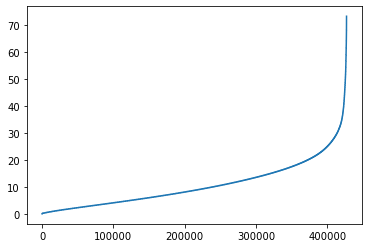

,source,target,serv_li,distance,serv_no
0,01012,01112,"12,12e,175,63,7,80",0.5,6
1,01012,01121,"12,175,2,2A,32,33,51,61,63,7,80",1.1,11
2,01012,01211,"12,175,2,2A,32,33,51,61,63,7,80",1.4,11
3,01012,01311,"12,175,2,2A,32,33,51,61,63,7,80",1.7,11
4,01012,80011,"12,2,2A,32,33,51,63,7,80",2.3,9
...,...,...,...,...,...
426943,99189,84069,9,10.9,1
426944,99189,84059,9,11.2,1
426945,99189,84049,9,11.7,1
426946,99189,84039,9,12.4,1
